# streeteasy_model: Model development and evaluation

The purpose of this notebook is to evaluate a series of models to predict the rental price of units in NYC.  The data were scraped from streeteasy.com from 11/02/2016 to 1/31/2017 and stored in the SQLite database, rentnyc_db.  This notebook summarizes model development and evaluation.

In [1]:
#add the main directory to the path for access to feateng.py modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
import sqlite3
import seaborn as sns
from feateng import standard_formatting as standard_formatting

# Overview
I. Format data <br>
II. Models <br>
III. Feature engineering and model fitting <br>
IV. Model evaluation <br>


# I. Format data
The data are split into a training and test set.  The training set uses data from 10-30-2016 to 12-31-2016 and the test set uses data from 1-1-2017 to 1-11-2016.  The data are found in the train_data and test_data tables in the rentnyc databse found at data/db/rentnyc_db.  The training set reflects only new listings after 1/1/2017 (duplicates are removed).

### Load the data from the database

In [14]:
#load data from the sqlite database.  
db_name = '../db/streeteasy_db'
train_table_name = 'train_data'
test_table_name = 'test_data'
con = sqlite3.connect(db_name)
df_train = pd.read_sql("SELECT * FROM %s" % (train_table_name),con)
df_test = pd.read_sql("SELECT * FROM %s" % (test_table_name),con)
#use only new listings in the test set not found in the training set
df_test = df_test[~df_test['data_id'].isin(df_train['data_id'])]
#create an 'test' column to indicate membership in test set, then combine
df_train['test_set'] = 0
df_test['test_set'] = 1
df = pd.concat([df_train,df_test],axis = 0)

### standard_formatting from the feateng.py module

The standard_formatting function from the feateng module will perform preliminary cleaning of the data in preparation for modeling. 

1. Outlier removal (see exploratory_analysis.ipynb for justification)
    - remove prices > $20,000 per month
    - remove sq_ft > 10,000
    - remove rooms > 15
    - remove beds > 8
    - remove baths > 6
    - remove data_id = 1965895 (incorrect listing)
<br><br>
2. Drop uninformative columns
    - data_id, link, address, realtor, borough
<br><br>
3. Feature encoding
    - One-hot-feature encoding of unit_type and neighborhood
<br><br>
4. Missing values: 
    - For sq_ft, rooms, baths, beds, and days_on_streeteasy, recode missing values from -1 to 0 and add a new indicator variable for missing values.  

In [16]:
#get some variable lists before formatting
unit_type_list = df['unit_type'].unique()
nhood_list_names = df['neighborhood'].unique()
#apply standard model formatting
df = standard_formatting(df)
df = df.drop('index',1)

# II. Models

Several different regression models were evaluated.  For simplicity, only results for L1-regularized (Lasso) regression are included here.  The advantage of this approach is that it is fast, provides interpretable coefficient estimates, and allows for "built-in" feature selection by pushing coefficients on uninformative variables to zero.  A disadvantage is that it assumes a linear relationship between all variables and may be sensitive to outliers.  Removal of outliers during preprocessing and exploration of nonlinear feature transformations should mitigate these concerns. 

Three-fold cross validation is used to select the regularization term.  Here, we explore only three potential values that were identified through preliminary exploration across a broader range.

Support vector regression with non-linear kernels and decision trees can be evaluated in the future to test whether non-linear models perform better.  


## 'model1': non-regularized linear regression

In [6]:
model1 = LinearRegression(fit_intercept=True,
                          normalize=False)

## 'model2': L1-regularized linear regression (Lasso) with CV

In [7]:
model2 = LassoCV(alphas = [.01,.1,.15],
                 normalize = False,
                 max_iter = 10000,
                 fit_intercept = True,
                 verbose = 1,
                 n_jobs = 3)

## 'model3': L2-regularized linear regression (Ridge) with CV

In [8]:
model3 = RidgeCV(alphas = [.01,.1,.15],
                 normalize = False,
                 fit_intercept = True)

## Model fitting function

In [9]:
def fit_model(model,df_x_train,df_y_train,df_x_test,df_y_test):
    """
    Given some scikit-learn model object, train the model and save some results in a dict.
    
    Parameters
    ----------
    model, scikit-learn model object
        - e.g., Lasso, LassoCV
    df_x_train, dataframe
        - dataframe (observations x features) for training set
    df_y_train, dataframe
        - single column data frame for target variable for training set
    df_x_test, dataframe
        - dataframe (observations x features) for test set
    df_y_test, dataframe
        - single column data frame for target variable for test set
        
    Returns
    -------
    result, dict with following keys:
        - 'pred', dict with 'train' and 'test' keys whose values are predictions for the train and test set, respectively
        - 'coef', model coefficients
        - 'alpha', best fitting regularization parameter
        - 'n_iter', number of iterations during optimization
    """
    #fit the model
    model = model.fit(df_x_train,df_y_train)
    #save the results in a dict
    result = {'pred':{},'coef':[]}
    result['pred']['test'] = model.predict(df_x_test)
    result['pred']['train'] = model.predict(df_x_train)
    result['coef'] = model.coef_
    result['alpha'] = model.alpha_
    result['n_iter'] = model.n_iter_
    #print some summary results
    print "rmse = %2.2f, r2 = %2.3f" % (np.sqrt(mean_squared_error(df_y_test,result['pred']['test'])), r2_score(df_y_test,result['pred']['test']))
    print "total features included (non-zero weight): %d" % (np.sum(np.abs(model.coef_)>0))
    return result

# III. Feature engineering and model fitting

We evaluate a series of models defined by increasing sets of features.  These include the following:<br>

1. 'reduced': a model that uses only features available through the Streeteasy API (bedrooms, neighborhood, unit type). 
 
2. 'scraped': a model that adds additional features scraped from the streeteasy web pages.  For now, amenities and transportation are excluded (sq_ft, bathrooms, total rooms, days on streeteasy).

3. 'amen': a model that includes all aforementioned features and also amenities for each listing.

4. 'trans": a model that includes all aforementioned features and also distances to nearby subway stops.

5. 'inter': a model that includes all aforementioned features and also interaction terms between neighborhood and several features. 

### Initialize some variables and functions to generate features

In [12]:
#initialize dicts to save model results and features sets
results = {'reduced':[],'scraped':[],'amen':[],'trans':[],'inter':[]}
feats = {'reduced':[],'scraped':[],'amen':[],'trans':[],'inter':[]}
pred = {'reduced':[],'scraped':[],'amen':[],'trans':[],'inter':[]}
#get feature lists for modification
nhood_list = [s for s in list(df.columns) if 'neighborhood' in s]
amen_list = ['bike_room', 'board_approval_required', 'cats_and_dogs_allowed',
             'central_air_conditioning', 'concierge', 'cold_storage', 'community_recreation_facilities',
             'children_playroom', 'deck', 'dishwasher', 'doorman', 'elevator', 'full_time_doorman',
             'furnished', 'garage_parking', 'green_building', 'gym', 'garden', 'guarantors_accepted',
             'laundry_in_building', 'live_in_super', 'loft', 'package_room', 'parking_available',
             'patio', 'pets_allowed', 'roof_deck', 'smoke_free', 'storage_available', 'sublet',
             'terrace', 'virtual_doorman', 'washer_dryer_in_unit', 'waterview', 'waterfront']
trans_list = ['line_A', 'line_C', 'line_E', 'line_B', 'line_D', 'line_F', 'line_M', 'line_G',
              'line_L', 'line_J', 'line_Z', 'line_N', 'line_Q', 'line_R', 'line_1', 'line_2',
              'line_3', 'line_4', 'line_5', 'line_6', 'line_7', 'line_S', 'LIRR', 'PATH']
#initialize function to split train/test
def split_train_test(df_all):
    """
    Split the target and predictor variables prior to fitting.
    """
    #split target(y) and predictor(x) variables
    df_y = df_all['price']
    df_x = df_all.drop(['price'],1)
    #split train test sets
    df = {'y':{},'x':{}}
    df['y']['train'] = df_y[df_x['test_set'] == 0]
    df['y']['test'] = df_y[df_x['test_set'] == 1]
    df['x']['train'] = df_x[df_x['test_set'] == 0]
    df['x']['test'] = df_x[df_x['test_set'] == 1]
    #drop test set labels
    df['x']['train'] = df['x']['train'].drop('test_set', axis = 1)
    df['x']['test'] = df['x']['test'].drop('test_set', axis = 1)
    #return the dict of dataframes
    return df

## Reduced features ('reduced')

The Streeteasy API provides some basic information about the median rental prices based on the number of bedrooms, neighborhood, and unit type without the need to scrape data.  We will first evaluate a model that uses only these features to establish a baseline level of performance.  If adding additional scraped variables does not significantly improve the model predictions, then we can save a lot of time by not investing in web scraping!     

In [13]:
#other variables to drop
drop_cols = ['days_on_streeteasy','sq_ft','rooms','baths','sq_ft_miss','rooms_miss','baths_miss','days_on_streeteasy_miss']
#drop amenities, transportation, other variables
feats['reduced'] = df.copy()
feats['reduced'] = feats['reduced'].drop(amen_list,axis=1)
feats['reduced'] = feats['reduced'].drop(trans_list,axis=1)
feats['reduced'] = feats['reduced'].drop(drop_cols,axis=1)
#split the features and target variable
feats['reduced'] = split_train_test(feats['reduced'])
#fit model2
results['reduced'] = fit_model(model2, feats['reduced']['x']['train'],feats['reduced']['y']['train'],feats['reduced']['x']['test'],feats['reduced']['y']['test'])

.........[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished


rmse = 1269.26, r2 = 0.487
total features included (non-zero weight): 252


## Scraped features, no amenities or transportation ('scraped')

Add to the existing feature set additional information that was only obtained by directly scraping it from the streeteasy listing web pages.  These include square feet, days listed on streeteasy, number of total rooms, and number of bathrooms.  We can comapre this model to the previous 'reduced' model to test whether the new scraped data significantly improves the quality of fit.  We can comapre this model to later models that add additional features to test whether more extensive scraping significantly improves the quality of fit.

In [17]:
#drop neighborhoods
feats['scraped'] = df.copy()
feats['scraped'] = feats['scraped'].drop(amen_list,axis=1)
feats['scraped'] = feats['scraped'].drop(trans_list,axis=1)
#split the features and target variable
feats['scraped'] = split_train_test(feats['scraped'])
#fit model2
results['scraped'] = fit_model(model2, feats['scraped']['x']['train'],feats['scraped']['y']['train'],feats['scraped']['x']['test'],feats['scraped']['y']['test'])

.........[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.5s finished


rmse = 960.00, r2 = 0.707
total features included (non-zero weight): 248


## Scraped features plus amenities ('amen')

Add features encoding the available amenitites for each listing.

In [18]:
#drop neighborhoods
feats['amen'] = df.copy()
feats['amen'] = feats['amen'].drop(trans_list,axis=1)
#split the features and target variable
feats['amen'] = split_train_test(feats['amen'])
#fit model2
results['amen'] = fit_model(model2, feats['amen']['x']['train'],feats['amen']['y']['train'],feats['amen']['x']['test'],feats['amen']['y']['test'])

.........[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.6s finished


rmse = 876.94, r2 = 0.755
total features included (non-zero weight): 284


## Scraped features plus transportation ('trans')

Add features encoding the distance to nearby subway and train lines.  

In [19]:
#split the features and target variable
feats['trans'] = df.copy()
feats['trans'] = split_train_test(feats['trans'])
#fit model2
results['trans'] = fit_model(model2, feats['trans']['x']['train'],feats['trans']['y']['train'],feats['trans']['x']['test'],feats['trans']['y']['test'])

.........[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.7s finished


rmse = 874.32, r2 = 0.757
total features included (non-zero weight): 311


## Interaction features ('inter')

Add interaction terms between the neighborhood and the number of rooms, beds, baths, square feet, and days on streeteasy.  Interaction terms for missing data indicator variables are also computed.

In [20]:
#copy the dataframe
feats['inter'] = df.copy()
#create interaction terms between rooms, beds, baths, sq_rt and neighborhood
print "Generating interaction terms..."
col_list = ['rooms','rooms_miss','beds','beds_miss','baths','baths_miss','sq_ft',
            'sq_ft_miss','days_on_streeteasy','days_on_streeteasy_miss']
for c in col_list:
    for n in nhood_list_names:
        new_col = '%s_%s' % (c,n)
        feats['inter'][new_col] = feats['inter'][c] * feats['inter']['neighborhood_' + n]
print "Interaction terms generated.  Fitting model..."
#split the features and target variable
feats['inter'] = split_train_test(feats['inter'])
#fit model2
results['inter'] = fit_model(model2, feats['inter']['x']['train'],feats['inter']['y']['train'],feats['inter']['x']['test'],feats['inter']['y']['test'])

Generating interaction terms...
Interaction terms generated.  Fitting model...


/Users/purcelba/anaconda/envs/Python2.7/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
.........[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.1min finished


rmse = 742.37, r2 = 0.824
total features included (non-zero weight): 1015


# IV. Model evaluation

In [21]:
#compute rmse and r2 for each model
model_list = results.keys()
rmse_list = {}
r2_list = {}
for m in model_list:
    rmse_list[m] = np.sqrt(mean_squared_error(feats[m]['y']['test'],results[m]['pred']['test']))
    r2_list[m] = r2_score(feats[m]['y']['test'],results[m]['pred']['test'])
#sort by number of params
labels = ['reduced','scraped','amen','trans','inter'] #order the labels
rmse_sorted = [rmse_list[r] for r in labels]
r2_sorted = [r2_list[r] for r in labels]

### Cross-validated RMSE

Plot the root mean squared error computed for the cross-vaidated test set for each model.  In each case, additional features improve the quality of fit.  The parallel_bootstrap GitHub repository contains code to generate confidence intervals on the model fit statistics to evaluate the statistical significance of these improvements.  


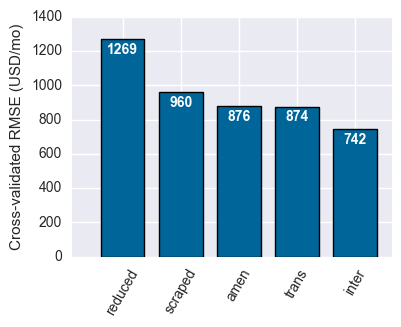

In [22]:
#save flag
save_on = False

#plot bar graph
sns.set_context("notebook", font_scale=1.0)
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([.2, .2, .4, .4])
sns.set_style("ticks")
sns.despine()
ind = np.array([1,2,3,4,5])
rect = ax.bar(ind,rmse_sorted,width=0.75,edgecolor='k',facecolor=[0,0.4,0.6],linewidth=1)
ax.set_xticks(ind+(0.75/2))
ax.set_xticklabels(labels,rotation=60)
ax.set_xlim([0.5,6])
ax.set_ylabel("Cross-validated RMSE (USD/mo)")
counter = 0
for r in rect:
    ax.text(r.get_x() + r.get_width()/2, r.get_height()-100, 
       '%d' % int(rmse_sorted[counter]), ha='center', va='bottom', color='w', fontweight='bold', fontsize=10)
    counter = counter+1
#save?
if save_on:
    plt.savefig('nested_models.pdf',format='pdf')
    

### Cross-validated r-squared

R squared values provide a scale free evaluation of the quality of fit.  Note that R squared here is not guaranteed to increase with additional features because here it is computed on a hold-out set that was not used for fitting.

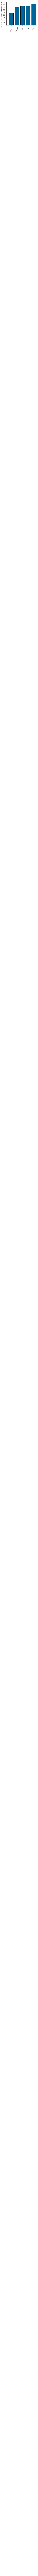

In [23]:
#save flag
save_on = False
#plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([.2, .2, .4, .4])
sns.set_style("ticks")
sns.despine()
ind = np.array([1,2,3,4,5])
rect = ax.bar(ind,r2_sorted,width=0.75,edgecolor='k',facecolor=[0,0.4,0.6],linewidth=1)
ax.set_xticks(ind+(0.75/2))
ax.set_xticklabels(labels,rotation=60)
ax.set_xlim([0.5,6])
ax.set_ylabel("% Variance Explained (Cross-validated)")
counter = 0
for r in rect:
    ax.text(r.get_x() + r.get_width()/2, r.get_height()-100, 
       '%d' % int(rmse_sorted[counter]), ha='center', va='bottom', color='w', fontweight='bold', fontsize=10)
    counter = counter+1
#save?
if save_on:
    plt.savefig('nested_models.pdf',format='pdf')


### Prediction error analysis
Are there systematic misses in model predictions?

In [29]:
#Compute residuals, save in dataframe
pred = results['inter']['pred']['test']
true = feats['inter']['y']['test']
x = feats['inter']['x']['test']
resid = pd.DataFrame(pred - true).rename(columns = {'price': 'resid'})
resid['price'] = true
resid['pred'] = pred

The overall distribution of prediction errors is symmetrical.  

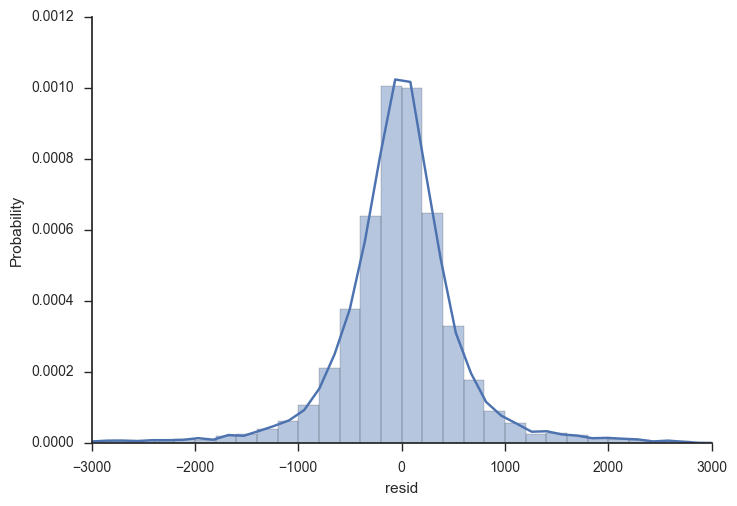

In [30]:
#histogram of residuals
from scipy.stats import norm
bins_ = np.arange(-10000,10000,200)
ax = sns.distplot(resid['resid'],bins=bins_,kde = True)
sns.despine()
ax.set_xlim([-3000,3000])
ax.set_ylabel('Probability')
#good, histogram is roughly symmetrical and normal, nothing systematic about model misses


The model tends to overpredict the price of very expensive rentals (>$10,000/month).  A separate model or additional transformations of the data may be needed to accurately model this very expensive listings.  For now, we should be cautious about interpreting predictions in this range.  

(0, 20000)

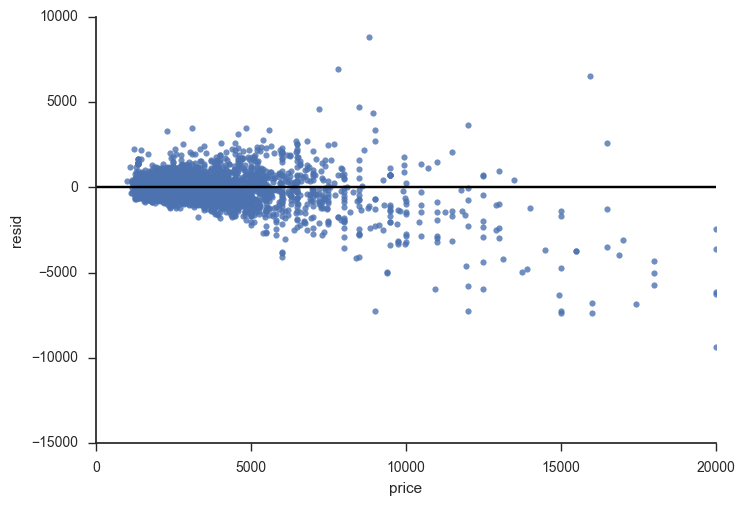

In [28]:
#residuals by price
ax = sns.regplot(resid['price'],resid['resid'],fit_reg = False)
sns.despine()
ax.plot([0,20000],[0,0],'k')
ax.set_xlim([0,20000])